In [1]:
%matplotlib notebook                      
import numpy as np                        # working with arrays
import imageio                            # reading images as an array
import matplotlib.pyplot as plt           # working with plots
import matplotlib.animation as animation  # working with animations & making gifs
import seaborn as sns                     # working with fancy plots
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import os                                 # sounds

from PIL import Image, ImageDraw          # rotating solidification front
from skimage.filters import gaussian
from skimage.measure import label, regionprops
from skimage import morphology as mrph
import skimage.measure as mea

#import get_valve_morphology as gvm

from skimage import transform as tf
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('~/jupyter-notebook/trial.mplstyle')

In [12]:
import warnings

Xmin = -230             # reactor boundaries
Xmax = +230
Ymin = -230
Ymax = +230

Xsize = Xmax-Xmin       # size of the X_Y grid
Ysize = Ymax-Ymin    
dx  = 1                 # space step in nm
dy  = dx                # dx = 8.5 nm

nX  = int(Xsize/dx)     # integer
nY  = int(Ysize/dy)

T  = 10000              # total time
dt = 1                  # time step
nt = int(T/dt)          # number of iterations

f      = 0.073          # equilibrium rate constant  
k_sol  = 0.135         # solidification rate

I_cr = 9.0              # quenching parameters
h = 20

delta = 2.05
Ds1i = 0.112            # diffusion constants 
Ds2i = Ds1i/delta
Di   = 0.1

CFLx = Di*dt/(dx**2)    # CFL satbility criterion

mag_facf = 90
mf=mag_facf
Xm,XM,Ym,YM =(Xmin/dx)/mf,(Xmax/dx)/mf,(Ymax/dx)/mf,(Ymin/dx)/mf
ds0 = 1

if (CFLx > 0.24 ) : warnings.warn("\n  CFL* HAS BEEN REACHED: CFL={:.3f}".format(CFLx))

print('Grid size (rows):...................{}'.format(nY))
print('Estimated simulation time (min):....{:.2f}'.format((4.5e-4*nX+5.12e-3)**2.3*T/dt/60)) # empirical func.
print('CFL (CFL*=0.16):....................{:.3f}'.format(CFLx))

Grid size (rows):...................460
Estimated simulation time (min):....4.71
CFL (CFL*=0.16):....................0.100


<IPython.core.display.Javascript object>


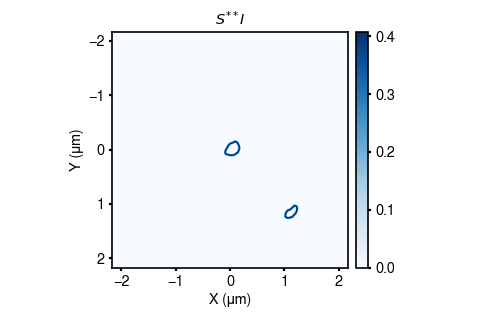

In [13]:
from skimage.transform import rescale

def get_initial_configuration(img,v_max,u_min):
    
    #delta = v_max-u_min
    pic = imageio.imread(img)            # image import, gray scale normalization and rescaling
    nS = np.shape(pic[1])[0]
    seed = pic[:,:,3]-pic[:,:,2]
    seed = seed/250
    seed = rescale(seed, 0.18/dx, multichannel=False, anti_aliasing=True)

    N = nX
    U = np.ones((N,N))                   # making blank U and V matrices
    V = np.zeros((N,N))
    
    N2 = N//2                            # inserting the seed in the center of the domain
    r = int(np.shape(seed)[0])
    V[N2-r//2:N2+r//2+r%2, N2-r//2:N2+r//2+r%2] =v_max*seed # how deal with odd and even shapes
    #U = U - V*(1-u_min)/v_max            # tuning the U,V initial conditions
    return U, V

# visulaization of U-V IC:
U, V = get_initial_configuration('seed_twos1.png',0.4,0.4) # relaxing state ,0.4,0.3

def plot_scale_bar(img,mgf,axes):
    im1 = axes.errorbar(np.shape(img)[0]*0.8,np.shape(img)[1]*0.08,\
                        xerr = (mgf*ds0/dx)/4, color='k', capsize=1,linewidth=2)
    im2 = axes.text(np.shape(img)[0]*0.8,np.shape(img)[1]*0.02,\
                   '500 nm', horizontalalignment='center', verticalalignment='top',fontsize = 10)
    return(im1,im2)

# plot pattern
fig, ax = plt.subplots(figsize = (6,4),dpi=100)

physical_boundaries = [Xm,XM,Ym,YM] # in um

ax = plt.subplot(111)
ax.set_title(r'$S^{**}I$')
im1 = ax.imshow(V, cmap='Blues',extent =physical_boundaries)

ax.set_xlabel('X (μm)')
ax.set_ylabel('Y (μm)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.10)
clb = fig.colorbar(im1, cax=cax, orientation='vertical')
plt.tight_layout()

#import get_valve_morphology as gvm



In [14]:
import laplacians as LAP

def hill_func(C_cr,lam,c):
    h = C_cr**lam/(C_cr**lam+c**lam)
    return(h)

In [18]:
T = 15000
n = int(T/dt)   


S1I, S2I = get_initial_configuration('seed_twos1.png',0.4,0.4)
S2I[310:350,310:350]=0
S1I = np.ones(np.shape(U))

S3 = np.zeros(np.shape(U))
I  = np.zeros(np.shape(U)) 
uni = np.ones(np.shape(U))
sol = 1*np.ones(np.shape(U))

sigma = 1
SDV_a, SDV_b = 200, 200

for i in range(n):      
    
    deltaS1I = Ds1i*LAP.SDV_laplacian_expanding(S1I,r_r=SDV_a,c_r=SDV_b,dx=1) 
    deltaS2I = Ds2i*LAP.SDV_laplacian_expanding(S2I,r_r=SDV_a,c_r=SDV_b,dx=1)
    deltaI   = Di*LAP.SDV_laplacian_expanding(I,r_r=SDV_a,c_r=SDV_b,dx=1)
    
    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    sol = hill_func(C_cr=I_cr/100,lam=h,c=I/100)  
    delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    sigma = 1*(1+delta)
   
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)
    
    if (i == 3500): 
        S1Iprim, S2Iprim = get_initial_configuration('seed_twos1.png',0.4,0.4)
        S2I[310:350,310:350] = S2Iprim[310:350,310:350]


0

<IPython.core.display.Javascript object>


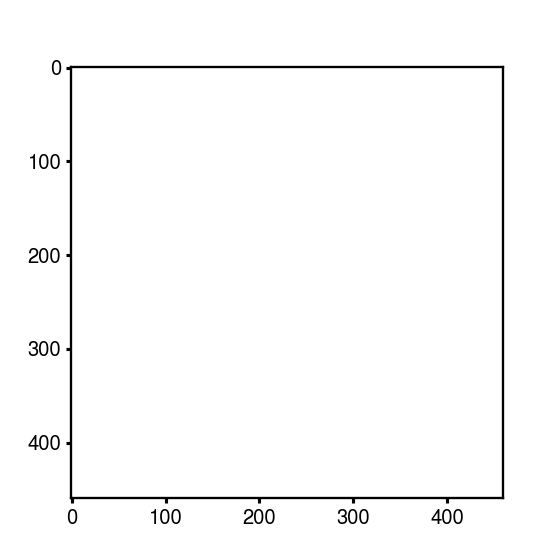

In [19]:
from skimage.draw import ellipse 

fig, ax = plt.subplots(figsize=(5,5),dpi=140)
ax = plt.subplot(111)

SDV_boundary = np.zeros((nY,nX))
rr, cc = ellipse(nY//2, nX//2, SDV_a, SDV_b)
SDV_boundary[rr, cc] = 1

skel = mrph.skeletonize((S3>10)*1)
skeleton_dilated = mrph.binary_dilation(skel, selem=mrph.disk(1))*1

im = ax.imshow(skeleton_dilated,cmap='Greys')

#plot_scale_bar(S3,mf,ax)
#ax.axis('off')